<a href="https://colab.research.google.com/github/akshaya-nagarajan/MachineLearning/blob/master/MLNodeRank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting Drive

In [166]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/MLSpring2020/"
base_dir = root_dir + 'the_expendables_AirQuality_Traffic'

Mounted at /content/gdrive


## Importing Libraries

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from dateutil.parser import parse 
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Liar Liar Dataset

In [0]:
liarFilepath = base_dir + '/Alternus_vera/liar_dataset/Liardataset.csv'

In [0]:
df_liar = pd.read_csv(liarFilepath, encoding= 'unicode_escape')

In [170]:
print('Liar-Liar - Fake and Truth Combined', df_liar.shape)

Liar-Liar - Fake and Truth Combined (12791, 14)


## Drop off unwanted columns

In [0]:
df_liar = df_liar.drop(columns=['json', 'subject', 'speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'])

In [172]:
df_liar.head(1)

,class,statement,speaker
0,FALSE,Says the Annies List political group supports ...,dwayne-bohac


## Code for getting the news source of the article as Politifact.com returns a node rank of 1.0 all the time. Therefore getting the direct source of the news article by scaping the URLs from Google search.

In [0]:
import urllib.request as urllib2
from lxml import html
import requests

def get_page_tree(url):
    page = requests.get(url=url, verify=False)
    return html.fromstring(page.text)

def get_title(url):
    tree = get_page_tree(url)
    return tree.xpath('//title//text()')[0].strip().split(' -')[0]

def find_other_news_sources(url,title):
    forwarding_identifier = '/url?q='
    if not title:
        title = get_title(url=url)
    google_news_search_url = 'http://www.google.com/search?q=' + urllib2.quote(title) + '&tbm=nws' + url
    google_news_search_tree = get_page_tree(url=google_news_search_url)
    other_news_sources_links = [a_link.replace(forwarding_identifier, '').split('&')[0] for a_link in google_news_search_tree.xpath('//a//@href') if forwarding_identifier in a_link]
    return other_news_sources_links

In [174]:
# df_liar['link'] = df_liar.head(1).apply(lambda x: find_other_news_sources("www.politifact.com", x['statement']), axis=1)
link = df_liar.head(1).apply(lambda x: find_other_news_sources("www.politifact.com", x['statement']), axis=1)
print(link[0])

['https://www.politifact.com/factchecks/2010/oct/20/dwayne-bohac/texas-rep-dwayne-bohac-says-annies-list-supports-t/', 'https://www.politifact.com/texas/article/2011/feb/01/pro-life-pro-choice-pro-truth/', 'https://www.theatlantic.com/politics/archive/2019/06/2020-democrats-abortion/590701/', 'https://www.washingtonpost.com/politics/amid-a-shifting-legal-landscape-on-abortion-both-parties-seek-political-advantage/2019/02/11/8e289cb4-2be1-11e9-b011-d8500644dc98_story.html', 'https://www.nytimes.com/2019/11/25/us/politics/abortion-laws-2020-democrats.html', 'https://www.npr.org/2019/04/30/718546468/opponents-fight-efforts-to-protect-late-term-abortion-rights', 'https://en.wikipedia.org/wiki/Abortion_law', 'https://en.wikipedia.org/wiki/Abortion_in_New_Zealand', 'https://www.jstor.org/stable/1228947', 'https://www.statesman.com/news/20200227/fact-check-do-democrats-support-abortion-up-until-and-after-birth', 'https://accounts.google.com/ServiceLogin%3Fcontinue%3Dhttp://www.google.com/sear

In [0]:
# for key, value in df_liar.iterrows():
#   if key >= 2433 and key <= 2434:    
#     value.link = find_other_news_sources("www.politifact.com", value.statement)
#     df_liar['link'][key] = value.link

In [0]:
# df_liar['link'][2433]

## Saving the Sources of 3000 scraped news articles URLs in CSV file.

In [0]:
# with open(base_dir + '/Alternus_vera/liarwithsource.csv', 'a') as f:
#   df_liar.to_csv(f)

In [0]:
liarWithSourceFilepath = base_dir + '/Alternus_vera/liarwithsource.csv'

In [0]:
df = pd.read_csv(liarWithSourceFilepath, encoding= 'unicode_escape')

In [180]:
df.shape

(3002, 6)

In [181]:
df.head(1)

,Unnamed: 0,class,statement,speaker,fakeness,link
0,0,FALSE,Says the Annies List political group supports ...,dwayne-bohac,1,['https://www.politifact.com/factchecks/2010/o...


## Dropping off unwanted columns

In [0]:
df = df.drop(columns=['Unnamed: 0', 'fakeness'])

In [183]:
df.head(10)

,class,statement,speaker,link
0,FALSE,Says the Annies List political group supports ...,dwayne-bohac,['https://www.politifact.com/factchecks/2010/o...
1,half-true,When did the decline of coal start? It started...,scott-surovell,['https://www.politifact.com/factchecks/2015/f...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,['https://www.politifact.com/factchecks/2008/f...
3,FALSE,Health care reform legislation is likely to ma...,blog-posting,['https://www.politifact.com/truth-o-meter/sta...
4,half-true,The economic turnaround started at the end of ...,charlie-crist,['https://www.politifact.com/factchecks/2014/m...
5,TRUE,The Chicago Bears have had more starting quart...,robin-vos,['https://www.politifact.com/factchecks/2016/j...
6,barely-true,Jim Dunnam has not lived in the district he re...,republican-party-texas,['https://www.politifact.com/factchecks/2010/s...
7,half-true,I'm the only person on this stage who has work...,barack-obama,['https://www.politifact.com/factchecks/2007/o...
8,half-true,"However, it took $19.5 million in Oregon Lotte...",oregon-lottery,['https://www.politifact.com/factchecks/2012/m...
9,mostly-true,Says GOP primary opponents Glenn Grothman and ...,duey-stroebel,['https://www.politifact.com/factchecks/2014/a...


## Cleaning the links from google search which has quotes and brackets.

In [0]:
def processLinks(link):
  allUrls = link.split(",")
  sourceList = []
  for i in range(len(allUrls)):
    sourceList.append(allUrls[i].replace('\'', '').replace('[', '').replace('\'', '').replace(' ', ''))
  return sourceList

In [0]:
df['source'] = df.apply(lambda x: processLinks(x['link']), axis=1)

## Cleaned links are stored in the source column

In [186]:
df['source']

0       [https://www.politifact.com/factchecks/2010/oc...
1       [https://www.politifact.com/factchecks/2015/fe...
2       [https://www.politifact.com/factchecks/2008/fe...
3       [https://www.politifact.com/truth-o-meter/stat...
4       [https://www.politifact.com/factchecks/2014/ma...
                              ...                        
2997    [https://www.politifact.com/factchecks/2008/fe...
2998    [https://www.politifact.com/factchecks/2012/no...
2999    [https://www.politifact.com/factchecks/2010/ju...
3000    [https://www.politifact.com/factchecks/2011/se...
3001    [https://www.thebalance.com/job-creation-by-pr...
Name: source, Length: 3002, dtype: object

In [187]:
df.head(1)

,class,statement,speaker,link,source
0,FALSE,Says the Annies List political group supports ...,dwayne-bohac,['https://www.politifact.com/factchecks/2010/o...,[https://www.politifact.com/factchecks/2010/oc...


## Considering the link (other than politifact domain) from a list of scraped Links from google search.

In [0]:
def considerSingleSource(links):
  link = ""
  for i in range(len(links)):
    if "politifact" not in links[i]:
      return links[i]
  return links[0]

In [0]:
df['singlesource']= df.apply(lambda x: considerSingleSource(x['source']), axis=1)

## Link for which pagerank/node rank is to be calculated is in singlesource column


In [190]:
df['singlesource']

0       https://www.theatlantic.com/politics/archive/2...
1       https://www.theatlantic.com/politics/archive/2...
2       https://www.outsidethebeltway.com/obama_ties_c...
3       https://www.cnbc.com/2018/03/27/work-health-in...
4       https://www.nbcnews.com/politics/politics-news...
                              ...                        
2997    https://www.investors.com/politics/editorials/...
2998      https://americansfortaxfairness.org/type/media/
2999    https://www.georgiastandards.org/Georgia-Stand...
3000    https://www.aei.org/economics/aging/how-genero...
3001    https://www.thebalance.com/job-creation-by-pre...
Name: singlesource, Length: 3002, dtype: object

In [191]:
df.head()

,class,statement,speaker,link,source,singlesource
0,FALSE,Says the Annies List political group supports ...,dwayne-bohac,['https://www.politifact.com/factchecks/2010/o...,[https://www.politifact.com/factchecks/2010/oc...,https://www.theatlantic.com/politics/archive/2...
1,half-true,When did the decline of coal start? It started...,scott-surovell,['https://www.politifact.com/factchecks/2015/f...,[https://www.politifact.com/factchecks/2015/fe...,https://www.theatlantic.com/politics/archive/2...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,['https://www.politifact.com/factchecks/2008/f...,[https://www.politifact.com/factchecks/2008/fe...,https://www.outsidethebeltway.com/obama_ties_c...
3,FALSE,Health care reform legislation is likely to ma...,blog-posting,['https://www.politifact.com/truth-o-meter/sta...,[https://www.politifact.com/truth-o-meter/stat...,https://www.cnbc.com/2018/03/27/work-health-in...
4,half-true,The economic turnaround started at the end of ...,charlie-crist,['https://www.politifact.com/factchecks/2014/m...,[https://www.politifact.com/factchecks/2014/ma...,https://www.nbcnews.com/politics/politics-news...


In [192]:
pip install git+https://github.com/mitsuhiko/flask-oauth

  Cloning https://github.com/mitsuhiko/flask-oauth to /tmp/pip-req-build-jgwh7tx5
  Running command git clone -q https://github.com/mitsuhiko/flask-oauth /tmp/pip-req-build-jgwh7tx5
  Running command git submodule update --init --recursive -q
  Created wheel for Flask-OAuth: filename=Flask_OAuth-0.13-cp36-none-any.whl size=7300 sha256=9c5b7ee7c152aa29c1ebc462790950efa87297298af787964eca73e803d052d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-gb26q5ok/wheels/c4/bc/23/62f2b06186a0307601258efa25becf1cb4b114a73c17eafecc
Successfully built Flask-OAuth


## Code to web scrape the URLs in singlesource column - Outlinks from the page, Calculating the Page rank, number of nodes and number of edges, finally constructing a graph for each node.

In [0]:
import subprocess
from urllib.parse import urlparse
try:
    import urllib.request as urllib2
except ImportError:
    import urllib2
from urllib.parse import urlencode
import socket
from multiprocessing import Queue
import threading
import getopt
import sys
import os
import networkx as nx
from bs4 import BeautifulSoup
import matplotlib

import matplotlib.pyplot as plt

import threading, queue
import re
q = queue.Queue()
max_threads=50
next_url=queue.Queue()
crawled_urls=[]

def check_link(url):
    domain = '.'.join(urlparse(url).netloc.split('.')[-2:])
    filetype = urlparse(url).path.split('/')[-1:][0].split('.')[-1:][0]
    if  (domain == 'politifact.com' and filetype != 'pdf'):
      return True
    else:
      return False

def get_host(url):
  try:
    return socket.gethostbyname(urlparse(url).netloc)
  except:
      pass
  return None

def get_links_from_page(url):
    urllist = []
    try:
      res=urllib2.urlopen(url)
      htmlpage=res.read()
    except:
      return urllist

    try:
      page=BeautifulSoup(htmlpage)
    except:
      return urllist

    #refs=page.findAll("a")
    pattern = re.compile(r"https://www.*.com/*")
    refs = page.findAll("a", href=pattern)[25:35]
    for a in refs:
      try:
        link = a['href']
        if link[:4] == 'http':
          urllist.append(link)
      except:
        pass

    return urllist

def find_links(url_tuple,graph):
    '''Crawls to a given depth using a tuple structure to tag urls with their depth'''
    global crawled_urls, next_url, max_depth
    url = url_tuple[0]
    depth = url_tuple[1]
    if (depth < 2) :
      links = get_links_from_page(url)
      for link in links:
        '''These two lines create the graph'''
        graph.add_node(link)
        graph.add_edge(url,link)
        '''If the link has not been crawled yet, add it in the queue with additional depth'''
        if link not in crawled_urls:
          next_url.put((link, depth+1))
          crawled_urls.append(link)
    return 

class crawler_thread(threading.Thread):
    def __init__(self,queue,graph):
      threading.Thread.__init__(self)
      self.to_be_crawled=queue
      self.graph=graph
      while self.to_be_crawled.empty() is False:
        find_links(self.to_be_crawled.get(), self.graph)

def draw_graph(graph, graph_file_name):
	'''Function to draw the graph and save the files'''
	nx.draw(graph,with_labels=False)
	nx.write_dot(graph,os.cwd()+graph_file_name+'.dot')
	plt.savefig(os.cwd()+graph_file_name+'.png')


In [0]:
# root_url = 'https://www.politico.com/story/2010/02/underwear-bomber-talking-again-032413' # --------- 0.005 , edges  -------- 6600, nodes --- 1900
# root_url='https://www.theatlantic.com/politics/archive/2019/06/2020-democrats-abortion/590701/'
# root_url = 'https://taxfoundation.org/summary-latest-federal-income-tax-data-2018-update/' # ------- 0.0042217689303551105 , edges ---- 160000, nodes ---2300

def calculatePageRank(url):
  print(str(url))
  root_url = url
  parser_flag = 'beautifulsoup'
  max_depth=2

  next_url.put((root_url,0))
  crawled_urls.append(root_url)
  ip_list=[]
  g=nx.Graph()
  g.add_node(root_url)
  thread_list=[]

  for i in range(max_threads): #changed
    t=crawler_thread(next_url,g)
    t.daemon=True
    t.start()
    thread_list.append(t)

  for t in thread_list:
    t.join()

  # for url in crawled_urls:
  #   ip_list.append(socket.gethostbyname(urlparse(url).netloc))
  #   ip_set=set(ip_list)
  #   ip_list = [*ip_set, ]

  # print("Unique Host: %s " % len(ip_list))
  pagerank = nx.pagerank_numpy(g, alpha=0.85, personalization=None,  weight='weight', dangling=None)
  edgeNumber = g.number_of_edges()
  nodeNumber = g.number_of_nodes()
  nodesize=[g.degree(n)*10 for n in g]
  pos=nx.spring_layout(g,iterations=20)

  nx.draw(g,with_labels=False)
  nx.draw_networkx_nodes(g,pos,node_size=nodesize,node_color='r')
  nx.draw_networkx_edges(g,pos)
  plt.figure(figsize=(5,5))
  plt.show()
  # return np.array(len(ip_list), pagerank.get(url), edgeNumber, nodeNumber)
  return pd.Series([pagerank.get(url), edgeNumber, nodeNumber], index=['pagerank','edges', 'nodes'])

## Graph Structure - Node represent the URLs and edges are the outlinks. Red nodes vary in size based on the degree of importance of the nodes. Each Article has many outlinks. For Simplicity, considering only 5 to 10 nodes in each article.

https://www.theatlantic.com/politics/archive/2019/06/2020-democrats-abortion/590701/


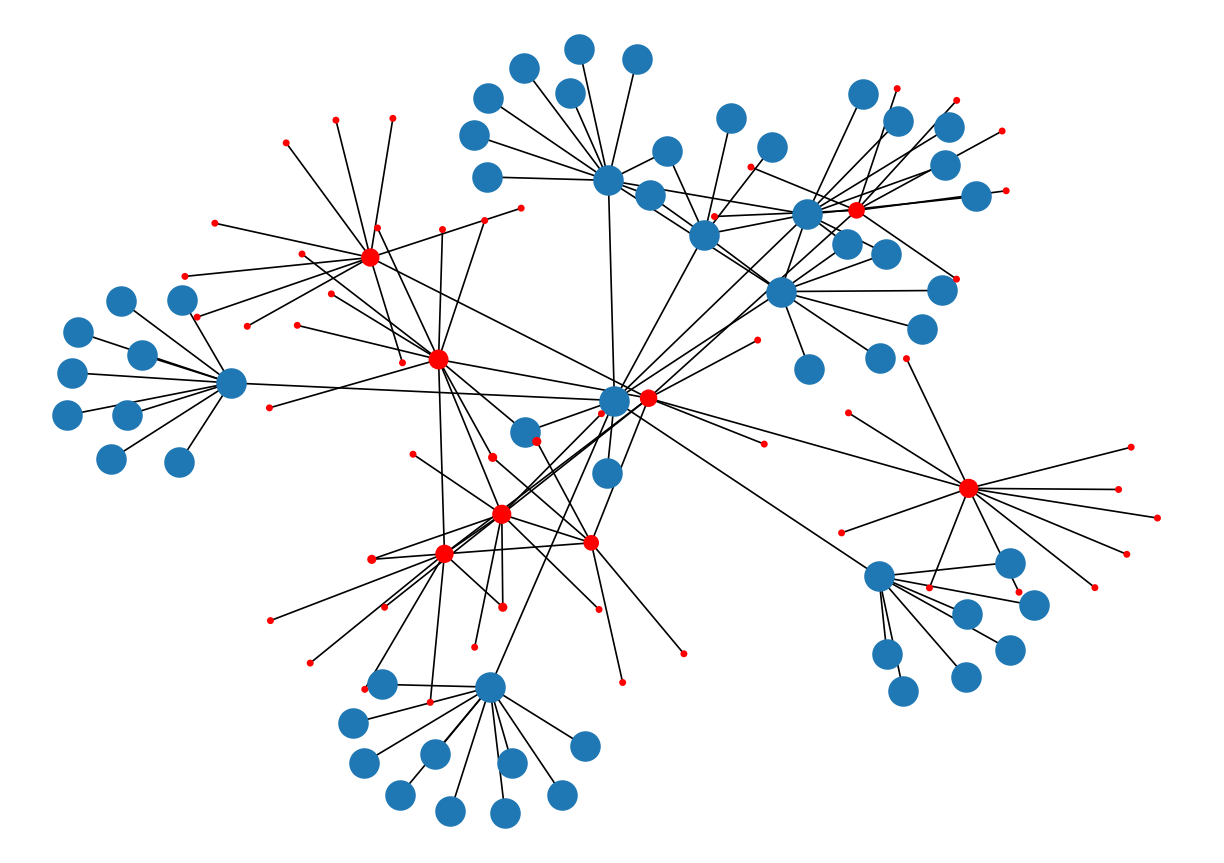

<Figure size 600x600 with 0 Axes>

https://www.theatlantic.com/politics/archive/2019/06/2020-democrats-abortion/590701/


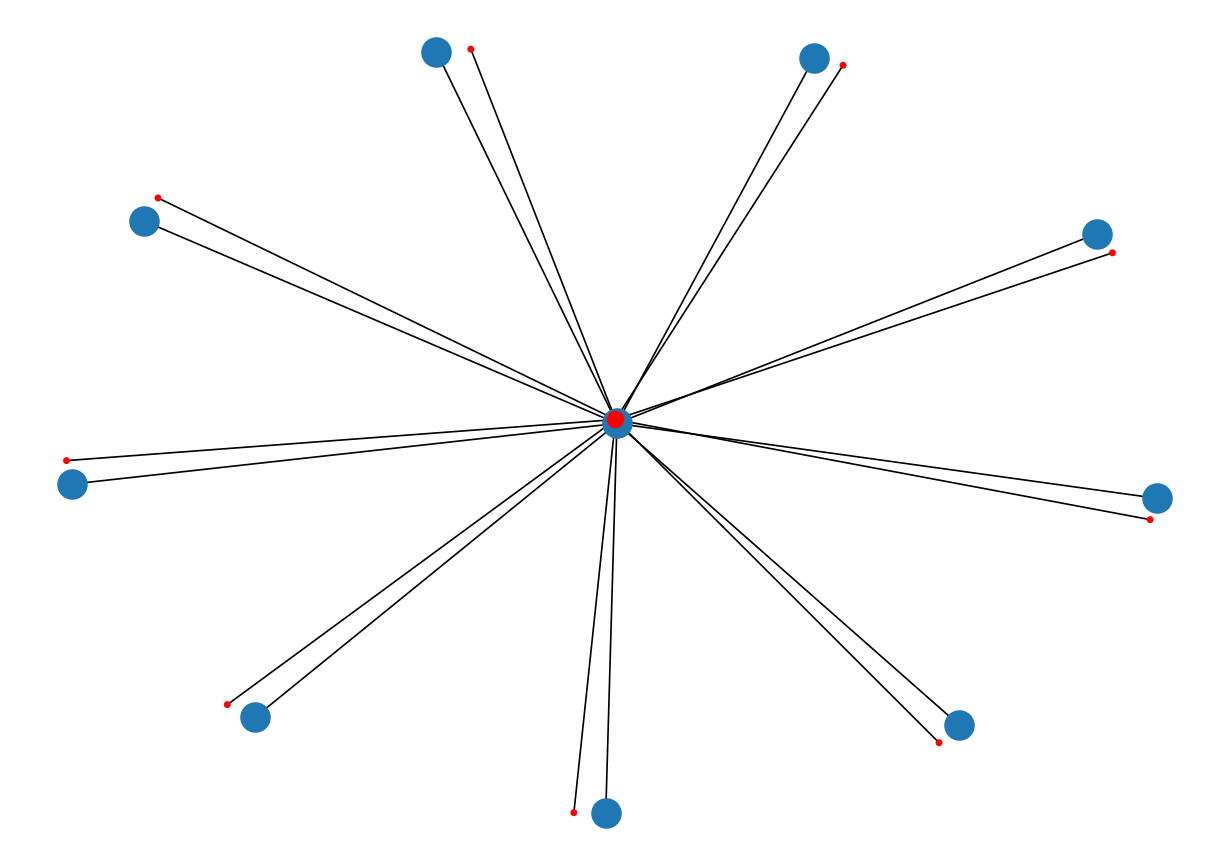

<Figure size 600x600 with 0 Axes>

In [205]:
df[['pagerank','edges', 'nodes']] = df.head(1).apply(lambda x: calculatePageRank(x['singlesource']), axis=1)

## Sample node rank/ number of edges and nodes calculation. This process consumes time. Therefore calculating them in batches and stored in CSV file below.

https://www.theatlantic.com/politics/archive/2019/06/2020-democrats-abortion/590701/


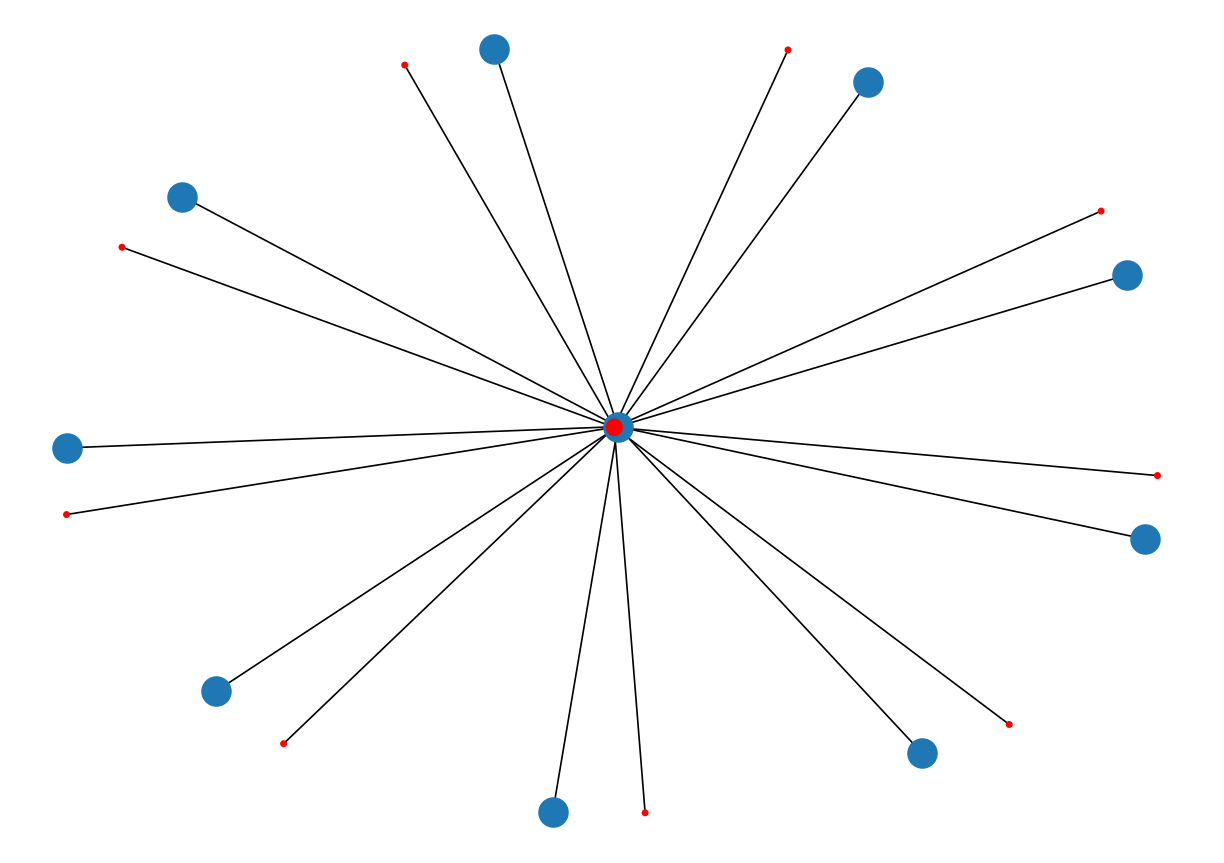

<Figure size 600x600 with 0 Axes>

0.4675675675675677
9.0
10.0
https://www.theatlantic.com/politics/archive/2013/10/coal-countrys-decline-has-a-long-history/453144/


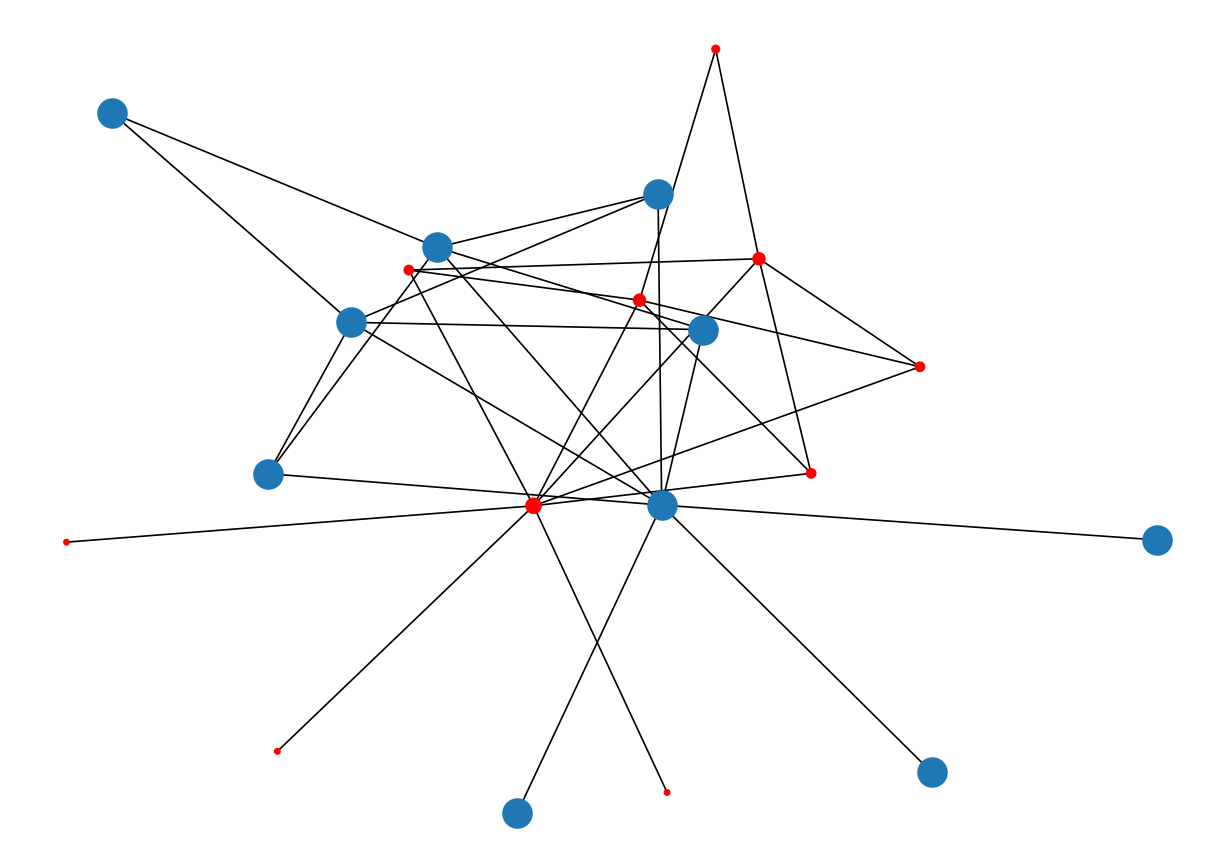

<Figure size 600x600 with 0 Axes>

0.24706192565772622
16.0
10.0
https://www.outsidethebeltway.com/obama_ties_clinton_policies_to_bushs/


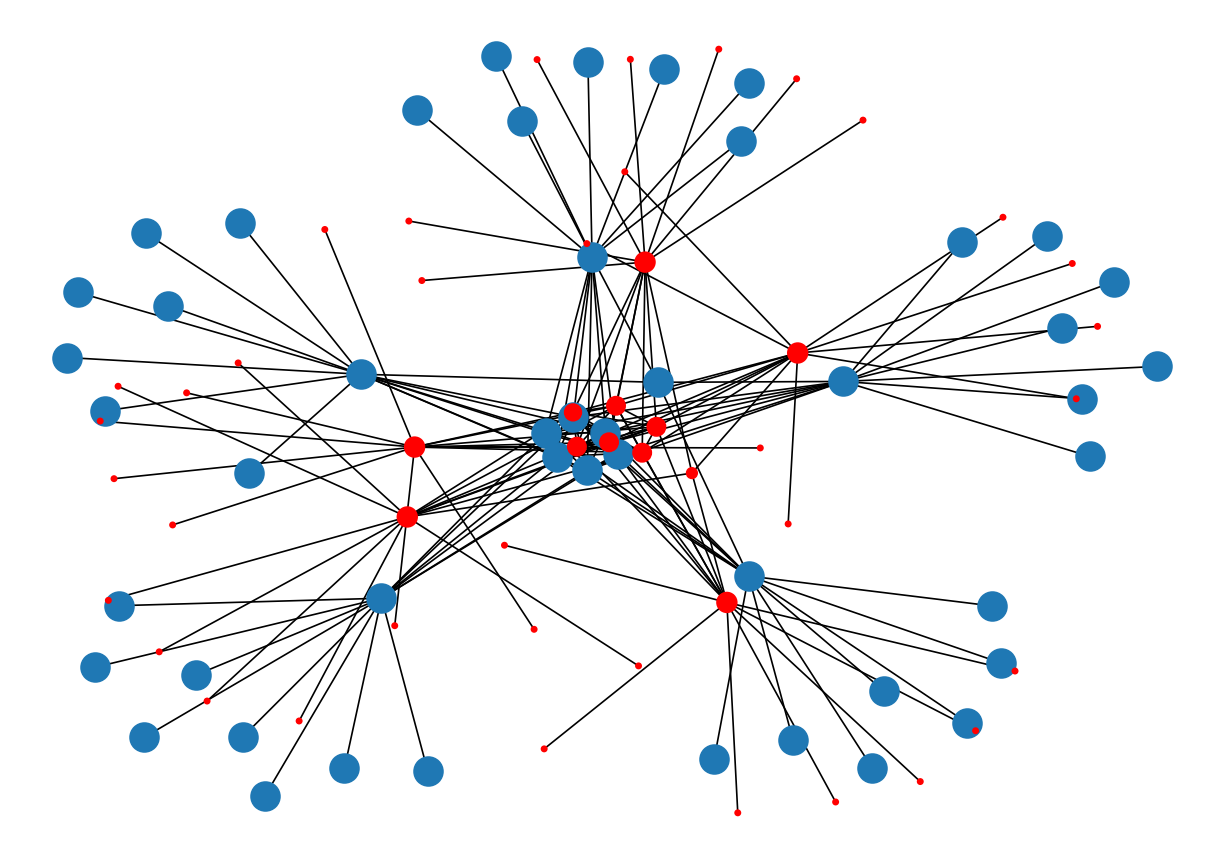

<Figure size 600x600 with 0 Axes>

0.046558446774521665
90.0
48.0


In [206]:
for key, value in df.iterrows():
  if key >= 0 and key <= 2:    
    value.pagerank, value.edges, value.nodes = calculatePageRank(value.singlesource)
    print(value.pagerank)
    print(value.edges)
    print(value.nodes)

## Loading the previously computed node rank, edges and nodes in dataframe for Liar-Liar dataset (100 values)

In [0]:
noderank_liar = base_dir + '/Alternus_vera/noderank.csv'

In [0]:
df_noderank_liar = pd.read_csv(noderank_liar, encoding= 'unicode_escape')

In [209]:
df_noderank_liar.head(10)

,Unnamed: 0,class,statement,speaker,link,source,singlesource,pagerank,edges,nodes
0,0,FALSE,Says the Annies List political group supports ...,dwayne-bohac,['https://www.politifact.com/factchecks/2010/o...,['https://www.politifact.com/factchecks/2010/o...,https://www.theatlantic.com/politics/archive/2...,0.486486,2.0,3.0
1,1,half-true,When did the decline of coal start? It started...,scott-surovell,['https://www.politifact.com/factchecks/2015/f...,['https://www.politifact.com/factchecks/2015/f...,https://www.theatlantic.com/politics/archive/2...,0.245492,4.0,5.0
2,2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,['https://www.politifact.com/factchecks/2008/f...,['https://www.politifact.com/factchecks/2008/f...,https://www.outsidethebeltway.com/obama_ties_c...,0.162838,6.0,6.0
3,3,FALSE,Health care reform legislation is likely to ma...,blog-posting,['https://www.politifact.com/truth-o-meter/sta...,['https://www.politifact.com/truth-o-meter/sta...,https://www.cnbc.com/2018/03/27/work-health-in...,0.259740,5.0,3.0
4,4,half-true,The economic turnaround started at the end of ...,charlie-crist,['https://www.politifact.com/factchecks/2014/m...,['https://www.politifact.com/factchecks/2014/m...,https://www.nbcnews.com/politics/politics-news...,0.259740,5.0,3.0
5,5,TRUE,The Chicago Bears have had more starting quart...,robin-vos,['https://www.politifact.com/factchecks/2016/j...,['https://www.politifact.com/factchecks/2016/j...,https://973therock.radiodubuque.com/sports/,1.000000,0.0,1.0
6,6,barely-true,Jim Dunnam has not lived in the district he re...,republican-party-texas,['https://www.politifact.com/factchecks/2010/s...,['https://www.politifact.com/factchecks/2010/s...,https://www.texasgop.org/texas-republicans-lau...,1.000000,0.0,1.0
7,7,half-true,I'm the only person on this stage who has work...,barack-obama,['https://www.politifact.com/factchecks/2007/o...,['https://www.politifact.com/factchecks/2007/o...,https://madison.com/ct/opinion/column/john_nic...,1.000000,0.0,1.0
8,8,half-true,"However, it took $19.5 million in Oregon Lotte...",oregon-lottery,['https://www.politifact.com/factchecks/2012/m...,['https://www.politifact.com/factchecks/2012/m...,https://www.oregonlive.com/politics/2012/03/ho...,0.350877,2.0,2.0
9,9,mostly-true,Says GOP primary opponents Glenn Grothman and ...,duey-stroebel,['https://www.politifact.com/factchecks/2014/a...,['https://www.politifact.com/factchecks/2014/a...,https://ballotpedia.org/Joseph_Leibham,1.000000,0.0,1.0


## Loading the previously computed node rank, edges and nodes in dataframe for News category Dataset

In [0]:
noderank_newscat = base_dir + '/Alternus_vera/noderanknewscat.csv'

In [0]:
df_noderank_newscat = pd.read_csv(noderank_newscat)

In [212]:
df_noderank_newscat.head(5)

,Unnamed: 0,headline,authors,link,short_description,pagerank,edges,nodes
0,13,Trump's Crackdown On Immigrant Parents Puts Mo...,Elise Foley and Roque Planas,https://www.huffingtonpost.com/entry/immigrant...,Last month a Health and Human Services officia...,1.0,0.0,1.0
1,14,'Trump's Son Should Be Concerned': FBI Obtaine...,"Michael Isikoff, Yahoo News",https://www.huffingtonpost.com/entry/fbi-wiret...,The wiretaps feature conversations between Ale...,1.0,0.0,1.0
2,15,Edward Snowden: There's No One Trump Loves Mor...,Mary Papenfuss,https://www.huffingtonpost.com/entry/edward-sn...,"But don't count on Robert Mueller to nail him,...",1.0,0.0,1.0
3,16,Booyah: Obama Photographer Hilariously Trolls ...,Mary Papenfuss,https://www.huffingtonpost.com/entry/obama-pho...,Just a peeping minute.,1.0,0.0,1.0
4,17,Ireland Votes To Repeal Abortion Amendment In ...,Laura Bassett,https://www.huffingtonpost.com/entry/results-f...,Irish women will no longer have to travel to t...,1.0,0.0,1.0
